# QED-C Application-Oriented Benchmarks - Modularized Qiskit Version
The notebook demonstrates problem generation, execution, and analysis of one of the many supported application-oriented benchmarks for the Qiskit API in a modularized fashion.   

Configure and run the cell below with the desired execution settings, then proceed to run the remaining cells.

In [1]:
min_qubits=2
max_qubits=8
skip_qubits=1
max_circuits=3
num_shots=1000


## Part 1: Problem Generation

Utilizing the new **_get_circuits_** flag in the architecture, we can supress execution and obtain only the problem generation components of interest.

The code below grabs the Bernstein-Vazirani Method 1 circuits and any metadata associated with them.

In [2]:
from bernstein_vazirani import bv_benchmark

circuits, metadata = bv_benchmark.run(
    min_qubits=min_qubits, max_qubits=max_qubits, skip_qubits=skip_qubits,
    max_circuits=max_circuits, num_shots=num_shots, method=1, get_circuits=True
)

print(f"\nCircuits:\n{circuits}")
print(f"\nMetadata: \n{metadata}")

Bernstein-Vazirani (1) Benchmark Program - Qiskit
... execution starting at Sep 29, 2025 05:18:39 UTC
************
Creating [3] circuits with num_qubits = 3
************
Creating [3] circuits with num_qubits = 4
************
Creating [3] circuits with num_qubits = 5
************
Creating [3] circuits with num_qubits = 6
************
Creating [3] circuits with num_qubits = 7
************
Creating [3] circuits with num_qubits = 8
************
Returning circuits and circuit information

Circuits:
{'3': {'1': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C08575D0>, '2': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA48DF50>}, '4': {'1': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA4E6A10>, '3': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C0875CD0>, '5': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA561550>}, '5': {'2': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000027

### The Circuits and Metadata
Note the format of the outputs:
- **circuits**: dict[str, dict[str, QuantumCircuit]] 
- **metadata**: dict[str, dict[str, dict[str, float]] | str]

Where 
1. The **first dictionary's key** represents the **number of qubits** for the group. In _metadata_, it may also serve as the subtitle.
2. The **second dictionary's key** represents the **unique identifier** for a circuit in the group. This may be a secret string for Bernstein-Vazirani, theta value for Phase-Estimation, and so on. Benchmark specific documentation can be found in our repository.
3. The **third dictionary's key** represents the **metric being stored** in _metadata_. (There is no third dictionary in _circuits_).

## Part 2: Execution

Now that we have the Qiskit circuits, we are free to run them using any execution framework that supports Qiskit!

### Preprocessing and Additional Metrics
We first convert the _circuits_ dictionary into a flat list; additionally, we choose to compute additional metrics and store them in the metrics module.

In [3]:
from _common import metrics
from _common.qiskit import execute as ex

# Remove the subtitle key for iterating purposes.
metadata.pop("subtitle", None)

# Copy any metadata from creation (i.e. create_time). This can be excluded if it's not of interest.
metrics.circuit_metrics = metadata

# Create a flat list of circuits.
circuit_identifiers = []
flat_circuits = []
for num_qubits in circuits.keys():
    for circuit_id in circuits[num_qubits].keys():
        circuit_identifiers.append((num_qubits, circuit_id))
        flat_circuits.append(circuits[num_qubits][circuit_id])

        # Optionally compute additional circuit properties (depth, etc.) and store to metrics.
        ex.compute_and_store_circuit_info(
            circuits[num_qubits][circuit_id],
            str(num_qubits),
            str(circuit_id),
            do_transpile_metrics=True,
            use_normalized_depth=True,
        )

print(f"Flat Circuits ({len(flat_circuits)}): \n{flat_circuits}\n")
print(f"Additional Metrics: \n{metrics.circuit_metrics}")

Flat Circuits (17): 
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C08575D0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA48DF50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA4E6A10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C0875CD0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA561550>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C08649D0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA5609D0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA48F050>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000273FA4E5250>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C0861F50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C0876CD0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000274C0867E90>, <qiskit.circuit.quantumcircuit.QuantumCircuit object a

## Running Circuits

We can choose to run on any execution platform that supports Qiskit circuits; for example, running through qBraid, _pyGSTi_, or a custom platform. 

For the sake of this demonstration, we will execute through a simple simulator.  

In [4]:
#TODO: Replace this with hardware. I was wondering if it's possible to use our Execution module instead.
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit_ibm_runtime import (QiskitRuntimeService,SamplerOptions,SamplerV2,Batch,Session)

use_sim = False

if use_sim:
    backend_id = "aer_simulator"
    backend = Aer.get_backend(backend_id)
    tqc = transpile(flat_circuits, backend)
    result = backend.run(tqc, shots=num_shots).result()

else:

    service = QiskitRuntimeService(
        channel="ibm_cloud",
        token='<YOUR TOKEN>',
        instance='<YOUR_CRN>'
        )
    backend = service.least_busy(
        operational=True, simulator=False, min_num_qubits=127
    )
    backend_id = backend.name
    print(backend)

    tqc = transpile(flat_circuits, backend)
    
    session = Batch(backend=backend)
    
    # Create a Sampler object
    sampler = SamplerV2(session, options=None)
    print(sampler)
    
    # Submit the circuits to Sampler
    job = sampler.run(tqc, shots=100)
    job_id = job.job_id()
    print(job_id)
    
    results = job.result()

    #print(f"... results = {results}")

    class BenchmarkResult2:

        def __init__(self, qiskit_result):
            super().__init__()
            self.qiskit_result = qiskit_result
            self.metadata = qiskit_result.metadata

            self.count_array = []
            for result in self.qiskit_result:    
                # convert the quasi distribution bit values to shots distribution
                bitvals = next(iter(result.data.values()))
                counts = bitvals.get_counts()
                self.count_array.append(counts)
    
        def get_counts(self, idx):
            return self.count_array[idx]
            
            # return raw counts object if only a single circuit executed, otherwise the array
            # this is done for consistency with all of the QED-C benchmark framework and Qiskit simulator
            #return count_array if len(count_array) > 1 else count_array[0]

    result = BenchmarkResult2(results)

    session.close()

#print(result)
    

<IBMBackend('ibm_brisbane')>
d3d1dd6dacis73dbdkg0


In [5]:
#print(result.get_counts())
#print(result)


## Part 3: Analysis and Results
After executing the circuits, we can use the counts to compute the fidelities, store them, and plot the results.

### Computing Fidelities
The code below uses the counts from above and stores them in the metrics module, which can then be used to create plots. 

In [6]:
from bernstein_vazirani import bv_benchmark

class CountsWrapper:
        """
        A wrapper class to enable support with QED-C's method to analyze results.
        """

        def __init__(self, counts: dict[str, int]):
            self.counts = counts

        def get_counts(self, _):
            return self.counts
            
# Iterate over each submitted circuit using the circuit identifiers:
for curr_idx, (num_qubits, circuit_id) in enumerate(
    ):
    # Wrap the counts
    counts = result.get_counts(curr_idx)
    result_obj = CountsWrapper(counts)
    
    # Compute the fidelity
    _, fidelity = bv_benchmark.analyze_and_print_result(
        None, result_obj, int(num_qubits), int(circuit_id), num_shots,
    )
    
    # Store the fidelity.
    metrics.store_metric(num_qubits, int(circuit_id), "fidelity", fidelity)

# Compute statistics for metrics.
metrics.aggregate_metrics()


### Visualization

Now that the fidelities are stored, we can use the metrics module to create plots. 

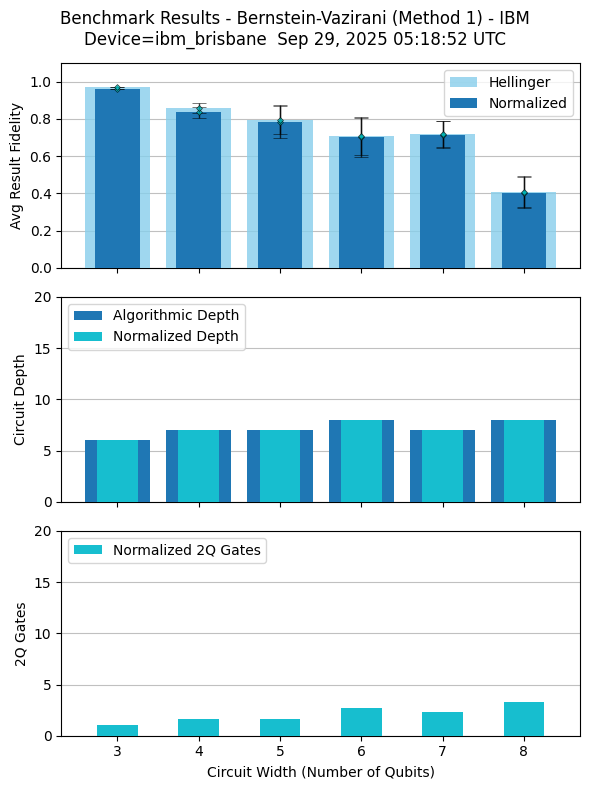

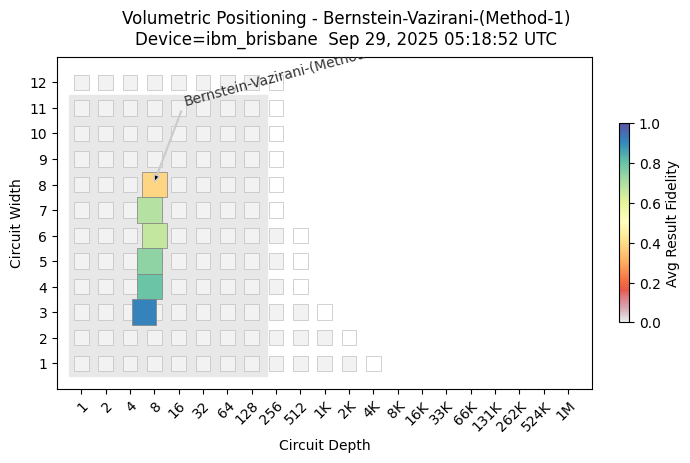

In [7]:
# Set information for plot titles.
benchmark_name = "Bernstein-Vazirani"
provider_name = "IBM"
device_name = backend_id

# Set plot titles.
benchmark_title = f"{benchmark_name} (Method 1)"
subtitle = f"Benchmark Results - {benchmark_title} - {provider_name}"
metrics.circuit_metrics["subtitle"] = f"device = {device_name}"

# Determine which metrics to plot.
filters = ["fidelity", "hf_fidelity", "depth", "2q", "vbplot"]

# Plot the metrics.
metrics.plot_metrics(subtitle, filters=filters)